# Pull Request Analysis

In [1]:
import psycopg2
import pandas as pd 
# from sqlalchemy.types import Integer, Text, String, DateTime
import sqlalchemy as s
import matplotlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json

with open("config.json") as config_file:
    config = json.load(config_file)

database_connection_string = 'postgres+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

dbschema='augur_data'
engine = s.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

## Pull Request Filter

In [2]:
## List of repository IDs for the report
repo_set = {26214, 26219, 25158, 26217, 26218}

# Identifying the Longest Running Pull Requests

## Getting the Data

In [3]:
pr_all = pd.DataFrame()

for repo_id in repo_set: 

    pr_slow20query = f"""
                    SELECT
                        repo.repo_id AS repo_id,
                        pull_requests.pr_src_id AS pr_src_id,
                        repo.repo_name AS repo_name,
                        repo_groups.rg_name AS repo_group,
                        pull_requests.pr_src_state,
                        pull_requests.pr_created_at AS pr_created_at,
                        pull_requests.pr_closed_at AS pr_closed_at,
                        date_part( 'year', pr_created_at :: DATE ) AS CREATED_YEAR,
                        date_part( 'month', pr_created_at :: DATE ) AS CREATED_MONTH,
						date_part( 'year', pr_closed_at :: DATE ) AS CLOSED_YEAR,
                        date_part( 'month', pr_closed_at :: DATE ) AS CLOSED_MONTH,
                        ( EXTRACT ( EPOCH FROM pull_requests.pr_closed_at ) - EXTRACT ( EPOCH FROM pull_requests.pr_created_at ) ) / 3600 AS hours_to_close,
                        ( EXTRACT ( EPOCH FROM pull_requests.pr_closed_at ) - EXTRACT ( EPOCH FROM pull_requests.pr_created_at ) ) / 86400 AS days_to_close, 
                        pull_requests.pr_html_url as pr_url, pull_requests.pr_src_title as pr_title
                    FROM
                        repo,
                        repo_groups,
                        pull_requests 
                    WHERE
                        repo.repo_group_id = repo_groups.repo_group_id 
                        AND repo.repo_id = pull_requests.repo_id 
                        AND repo.repo_id = {repo_id} 
                        --AND pull_requests.pr_src_state = 'closed' 
                    ORDER BY
                       hours_to_close desc

        """
    pr_slow20a = pd.read_sql_query(pr_slow20query, con=engine)
    if not pr_all.empty: 
        pr_all = pd.concat([pr_all, pr_slow20a]) 
    else: 
        # first repo
        pr_all = pr_slow20a
pr_all.set_index('pr_closed_at')#,'repo_id', 'pr_src_id', )
pr_all.head(1)

,repo_id,pr_src_id,repo_name,repo_group,pr_src_state,pr_created_at,pr_closed_at,created_year,created_month,closed_year,closed_month,hours_to_close,days_to_close,pr_url,pr_title
0,25158,282265766,zephyr,Zephyr-RTOS,open,2019-05-26 02:02:06,NaT,2019.0,5.0,NaN,NaN,NaN,NaN,https://github.com/zephyrproject-rtos/zephyr/p...,net: lwm2m: Add COAP-HTTP proxy URI configurat...


In [4]:
# Disabled end_date filtering for now to include PRs that are still open

start_date = pd.to_datetime('2017-07-01 01:00:00')
# end_date = pd.to_datetime('2020-02-01 09:00:00')
pr_all = pr_all[(pr_all['pr_created_at'] > start_date)]# & (pr_all['pr_closed_at'] < end_date)]

pr_all['created_year'] = pr_all['created_year'].map(int)
pr_all['created_month'] = pr_all['created_month'].map(int)
pr_all['created_month'] = pr_all['created_month'].map(lambda x: '{0:0>2}'.format(x))
pr_all['created_yearmonth'] = pd.to_datetime(pr_all['created_year'].map(str) + '-' + pr_all['created_month'].map(str) + '-01')
pr_all.head(1)

,repo_id,pr_src_id,repo_name,repo_group,pr_src_state,pr_created_at,pr_closed_at,created_year,created_month,closed_year,closed_month,hours_to_close,days_to_close,pr_url,pr_title,created_yearmonth
0,25158,282265766,zephyr,Zephyr-RTOS,open,2019-05-26 02:02:06,NaT,2019,05,NaN,NaN,NaN,NaN,https://github.com/zephyrproject-rtos/zephyr/p...,net: lwm2m: Add COAP-HTTP proxy URI configurat...,2019-05-01


In [17]:
import datetime
# getting the number of days of (today - created at) for the PRs that are still open
# and putting this in the days_to_close column

days_to_close_open_pr = datetime.datetime.now() - pr_all.loc[pr_all['pr_src_state'] == 'open']['pr_created_at']
days_to_close_open_pr = days_to_close_open_pr.apply(lambda x: x.days).astype(float)
pr_all.loc[pr_all['pr_src_state'] == 'open'] = pr_all.loc[pr_all['pr_src_state'] == 'open'].assign(days_to_close=days_to_close_open_pr)

pr_all['closed_yearmonth'] = pd.to_datetime(np.nan)

pr_all.describe()

,created_year,closed_year,closed_month,hours_to_close,days_to_close
count,24917.000000,23564.000000,23564.000000,23564.000000,24917.000000
mean,2018.367982,2018.378119,6.871032,433.629984,27.502082
std,0.740135,0.725458,3.442479,1343.900954,80.805164
min,2017.000000,2017.000000,1.000000,0.001389,0.000058
25%,2018.000000,2018.000000,4.000000,7.750833,0.382454
50%,2018.000000,2018.000000,7.000000,53.611667,2.860926
75%,2019.000000,2019.000000,10.000000,251.806111,14.200185
max,2020.000000,2020.000000,12.000000,21144.195000,945.000000


In [18]:
# Extra operations/fields for closed pr df

pr_all.loc[pr_all['pr_src_state'] == 'closed'] = pr_all.loc[pr_all['pr_src_state'] == 'closed'].assign(closed_yearmonth=pd.to_datetime(pr_all.loc[pr_all['pr_src_state'] == 'closed']['closed_year'].astype(int).map(str) + '-' + pr_all.loc[pr_all['pr_src_state'] == 'closed']['closed_month'].astype(int).map(str) + '-01'))
pr_all.dtypes

repo_id                      object
pr_src_id                    object
repo_name                    object
repo_group                   object
pr_src_state                 object
pr_created_at        datetime64[ns]
pr_closed_at         datetime64[ns]
created_year                  int64
created_month                object
closed_year                 float64
closed_month                float64
hours_to_close              float64
days_to_close               float64
pr_url                       object
pr_title                     object
created_yearmonth    datetime64[ns]
closed_yearmonth     datetime64[ns]
dtype: object

In [19]:
pr_all.set_index('repo_id')

# Isolate the different state PRs for now
pr_open = pr_all.loc[pr_all['pr_src_state'] == 'open']
pr_closed = pr_all.loc[pr_all['pr_src_state'] == 'closed']

In [20]:
# Filtering the 80th percentile slowest PRs
import warnings
warnings.filterwarnings('ignore')

def filter_20_per_slowest(input_df):
    pr_slow20_filtered = pd.DataFrame()
    pr_slow20_x = pd.DataFrame()
    for value in repo_set: 
        if not pr_slow20_filtered.empty: 
            pr_slow20x = input_df.query('repo_id==@value')
            pr_slow20x['percentile_rank_local'] = pr_slow20x.days_to_close.rank(pct=True)
            pr_slow20x = pr_slow20x.query('percentile_rank_local >= .8', )
            pr_slow20_filtered = pd.concat([pr_slow20x, pr_slow20_filtered]) 
            reponame = str(value)
            filename = ''.join(['output/pr_slowest20pct', reponame, '.csv'])
            pr_slow20x.to_csv(filename)
        else: 
            # first time
            pr_slow20_filtered = input_df.copy()
            pr_slow20_filtered['percentile_rank_local'] = pr_slow20_filtered.days_to_close.rank(pct=True)
            pr_slow20_filtered = pr_slow20_filtered.query('percentile_rank_local >= .8', )
    print(pr_slow20_filtered.describe())
    return pr_slow20_filtered

pr_slow20_open = filter_20_per_slowest(pr_open)
pr_slow20_closed = filter_20_per_slowest(pr_closed)
pr_slow20_all = filter_20_per_slowest(pr_all)

       created_year  closed_year  closed_month  hours_to_close  days_to_close  \
count    385.000000          0.0           0.0             0.0     385.000000   
mean    2018.109091          NaN           NaN             NaN     545.002597   
std        0.648352          NaN           NaN             NaN     200.869937   
min     2017.000000          NaN           NaN             NaN      76.000000   
25%     2018.000000          NaN           NaN             NaN     393.000000   
50%     2018.000000          NaN           NaN             NaN     531.000000   
75%     2019.000000          NaN           NaN             NaN     694.000000   
max     2019.000000          NaN           NaN             NaN     945.000000   

       percentile_rank_local  
count             385.000000  
mean                0.900338  
std                 0.058251  
min                 0.800000  
25%                 0.849963  
50%                 0.900000  
75%                 0.950480  
max                 1.

In [28]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import datetime as dt

def visualize_mean_min_max(input_df, x_axis='closed_yearmonth', description='Closed', num_remove_min_outliers=0):

    # Set the df you want to build the viz's for
    driver_df = input_df.copy()
    
    driver_df = driver_df[['repo_id', 'repo_name', 'pr_src_id','created_yearmonth', 'closed_yearmonth', 'days_to_close']]

    driver_df.to_csv('output/c.pr_slow20small_{}.csv'.format(description))
    
    driver_df_mean = driver_df.groupby(['repo_id',x_axis, 'repo_name'],as_index=False).mean()
    driver_df_min = driver_df.groupby(['repo_id',x_axis, 'repo_name'],as_index=False).min()
    driver_df_max = driver_df.groupby(['repo_id',x_axis, 'repo_name'],as_index=False).max()
    
    driver_df.set_index(x_axis)
    
    
    # Total PRS Closed
    fig, ax = plt.subplots()
    # the size of A4 paper
    fig.set_size_inches(24, 8)
    plotter = sns.lineplot(x=x_axis, y='days_to_close', style='repo_name', data=driver_df_mean, sort=True, legend='full', linewidth=2.5, hue='repo_name').set_title("Average Days to Close of Slowest 20% of {} Pull Requests, July 2017-January 2020".format(description))  
    #ax.tick_params(axis='x', which='minor', labelsize='small', labelcolor='m', rotation=30)
    #plotterlabels = ax.set_xticklabels(pr_slow20_mean['closed_yearmonth'], rotation=90, fontsize=8)
    fig.savefig('images/slow_20_mean_{}.png'.format(description))

    
    # Total PRS Closed
    fig, ax = plt.subplots()
    # the size of A4 paper
    fig.set_size_inches(24, 8)
    plotter = sns.lineplot(x=x_axis, y='days_to_close', style='repo_name', data=driver_df_min, sort=False, legend='full', linewidth=2.5, hue='repo_name').set_title("Minimum Days to Close among Slowest 20% of {} Pull Requests, July 2017-January 2020".format(description))
    #ax.tick_params(axis='x', which='minor', labelsize='small', labelcolor='m', rotation=30)
    plotterlabels = ax.set_xticklabels(driver_df_min[x_axis], rotation=90, fontsize=8)
    fig.savefig('images/slow_20_min_{}.png'.format(description))
    
    
    # Copying array and deleting the outlier in the copy to re-visualize
    def drop_n_largest(input_df, n, repo_name):
        input_df_copy = input_df.copy()
        indices_to_drop = input_df.loc[input_df['repo_name'] == 'amazon-freertos'].nlargest(n,'days_to_close').index
        print("Indices to drop: {}".format(indices_to_drop))
        input_df_copy = input_df_copy.drop(index=indices_to_drop)
        input_df_copy.loc[input_df['repo_name'] == repo_name]
        return input_df_copy

    if num_remove_min_outliers > 0:
        driver_df_min_no_outliers = drop_n_largest(driver_df_min, num_remove_min_outliers, 'amazon-freertos')
    
        # Total PRS Closed without outlier
        fig, ax = plt.subplots()
        # the size of A4 paper
        fig.set_size_inches(24, 8)
        plotter = sns.lineplot(x=x_axis, y='days_to_close', style='repo_name', data=driver_df_min_no_outliers, sort=False, legend='full', linewidth=2.5, hue='repo_name').set_title("Minimum Days to Close among Slowest 20% of {} Pull Requests Without Outlier, July 2017-January 2020".format(description))
        #ax.tick_params(axis='x', which='minor', labelsize='small', labelcolor='m', rotation=30)
        plotterlabels = ax.set_xticklabels(driver_df_min_no_outliers[x_axis], rotation=90, fontsize=8)
        fig.savefig('images/slow_20_min_no_outlier_{}.png'.format(description))
    
    
    fig, ax = plt.subplots()
    # the size of A4 paper
    fig.set_size_inches(24, 8)
    plotter = sns.lineplot(x=x_axis, y='days_to_close', style='repo_name', data=driver_df_max, sort=False, legend='full', linewidth=2.5, hue='repo_name').set_title("Maximum Days to Close among Slowest 20% of {} Pull Requests, July 2017-January 2020".format(description))   
    #ax.tick_params(axis='x', which='minor', labelsize='small', labelcolor='m', rotation=30)
    plotterlabels = ax.set_xticklabels(driver_df_max[x_axis], rotation=90, fontsize=8)
    fig.savefig('images/slow_20_max_{}.png'.format(description))

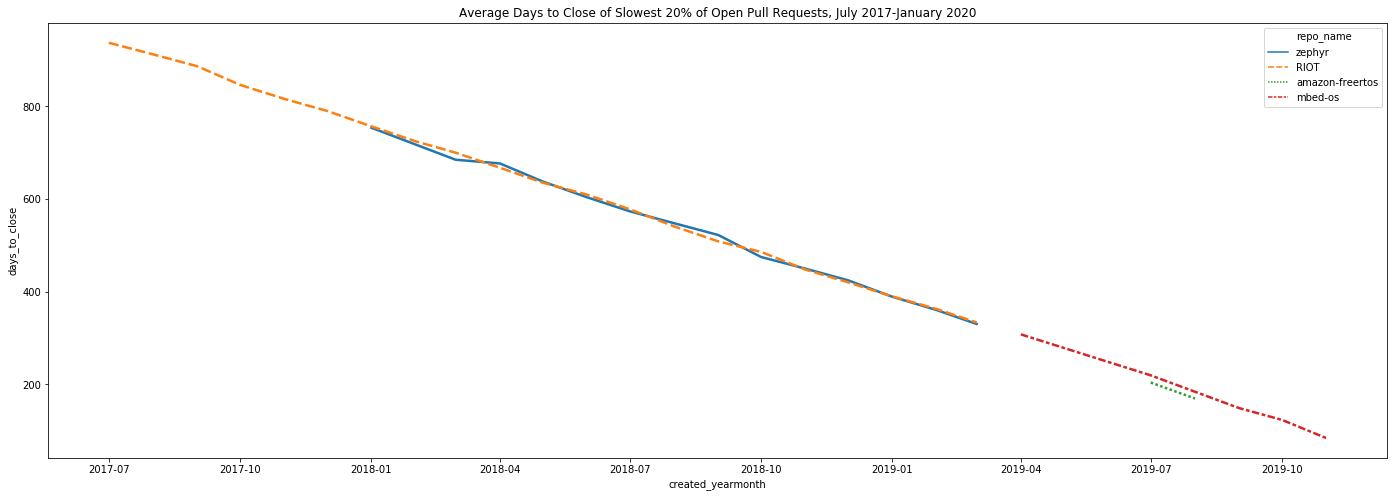

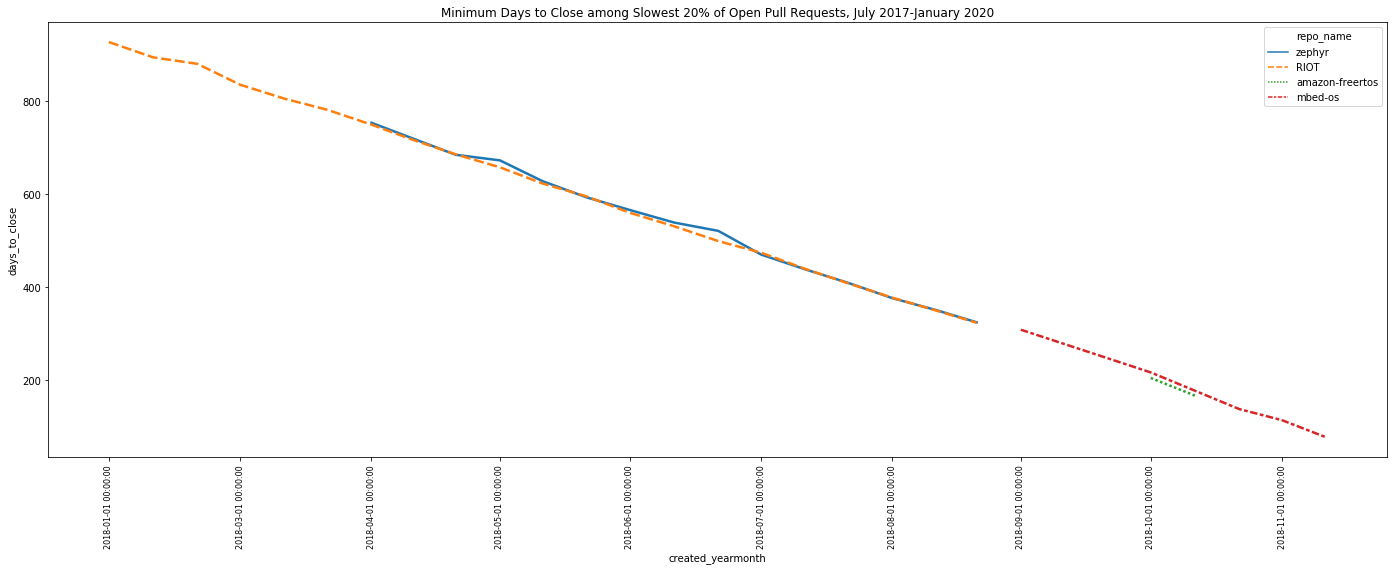

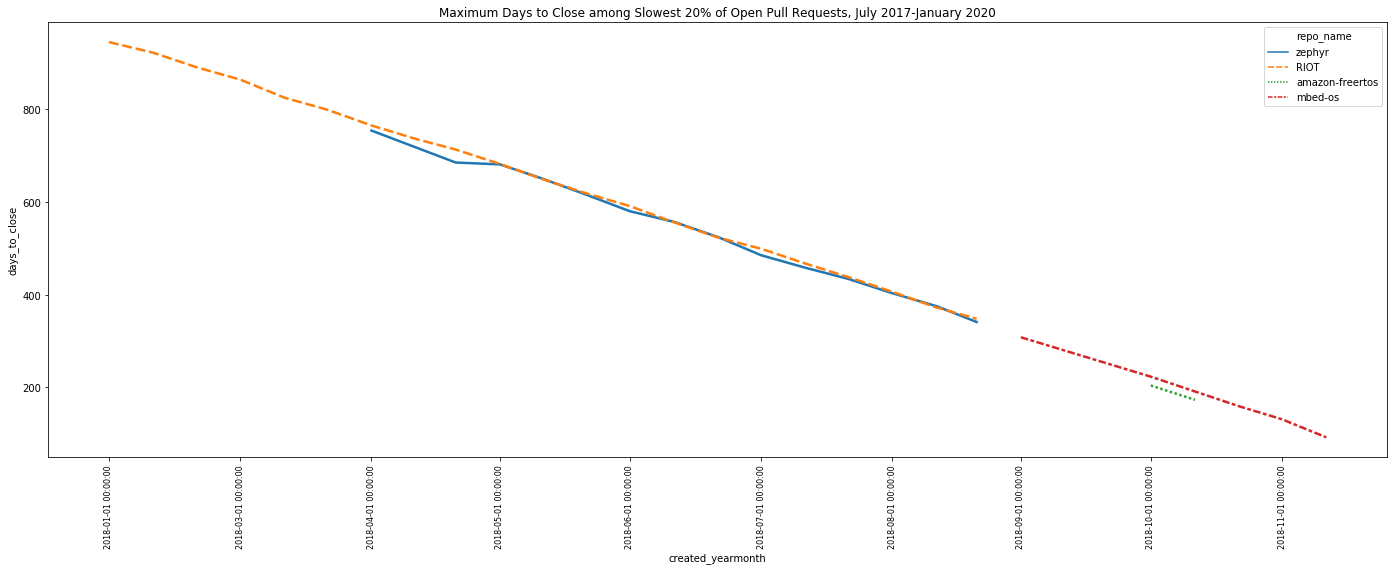

In [29]:
visualize_mean_min_max(pr_slow20_open, x_axis='created_yearmonth', description='Open', num_remove_min_outliers=0)

Indices to drop: Int64Index([61, 60, 63, 67, 62], dtype='int64')


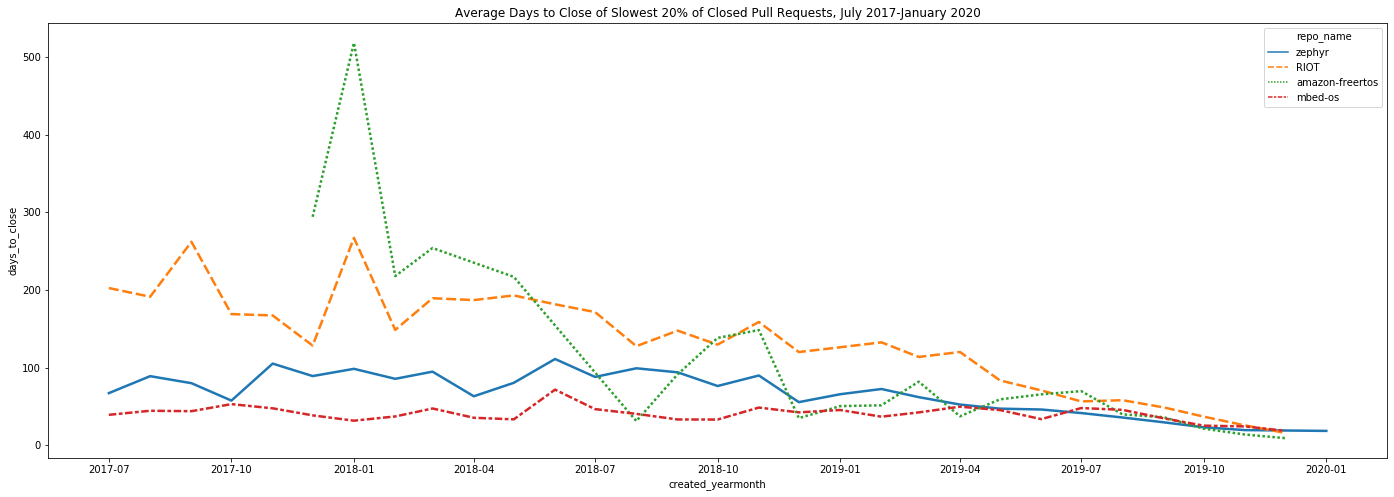

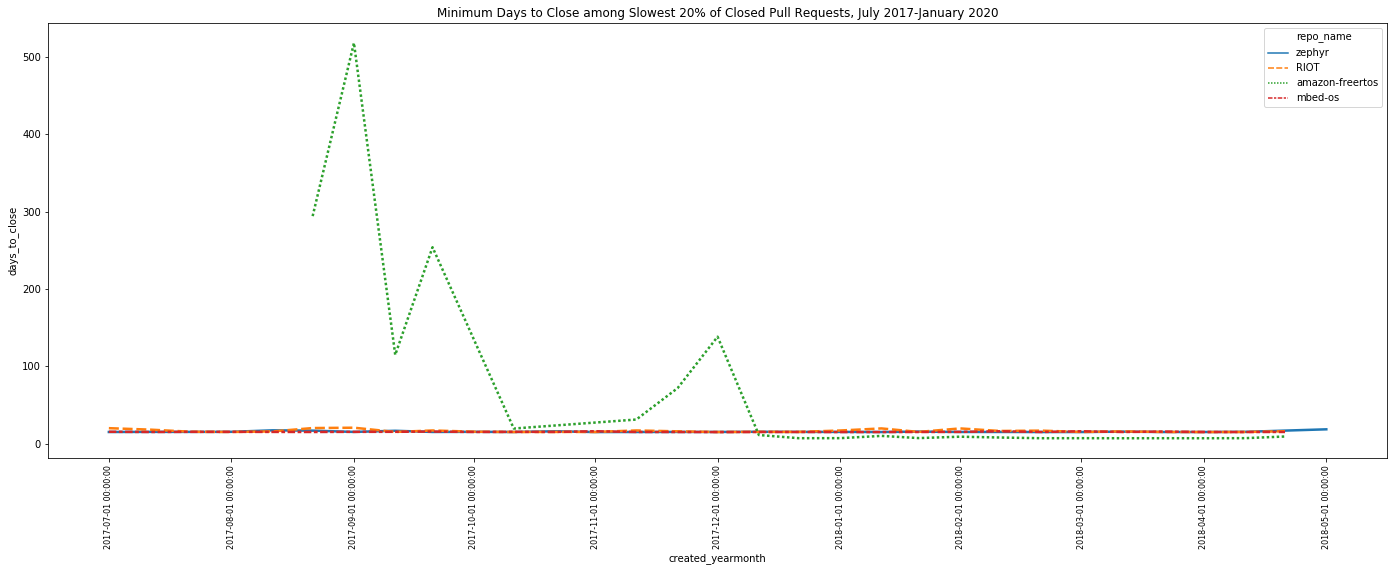

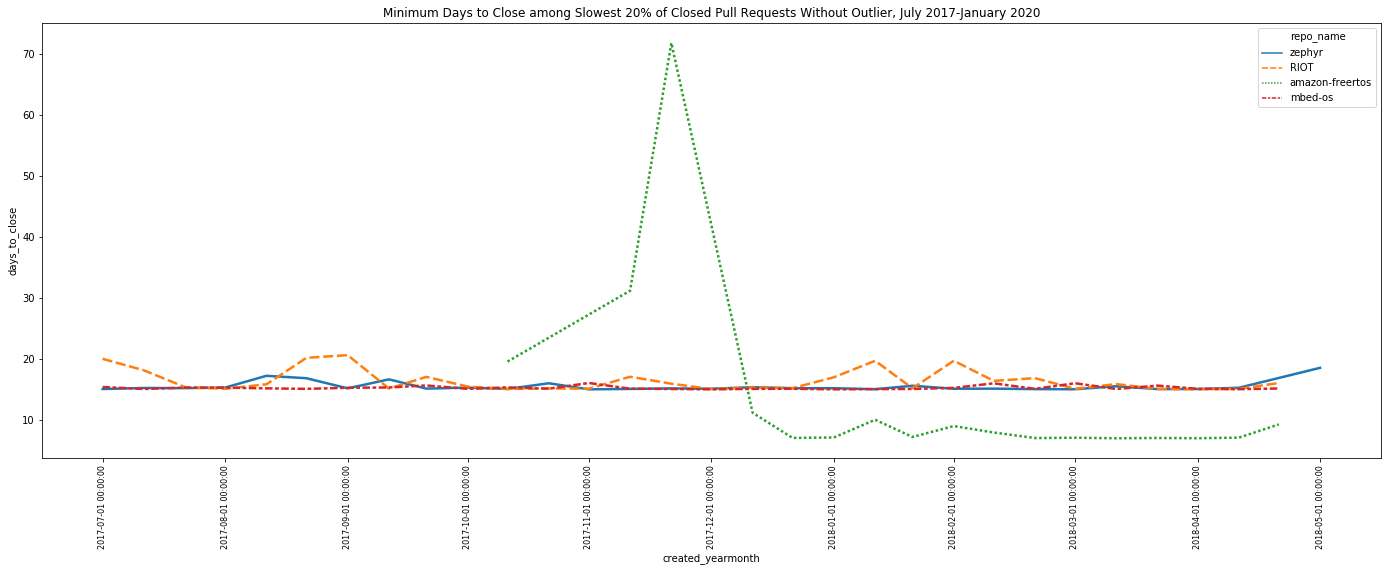

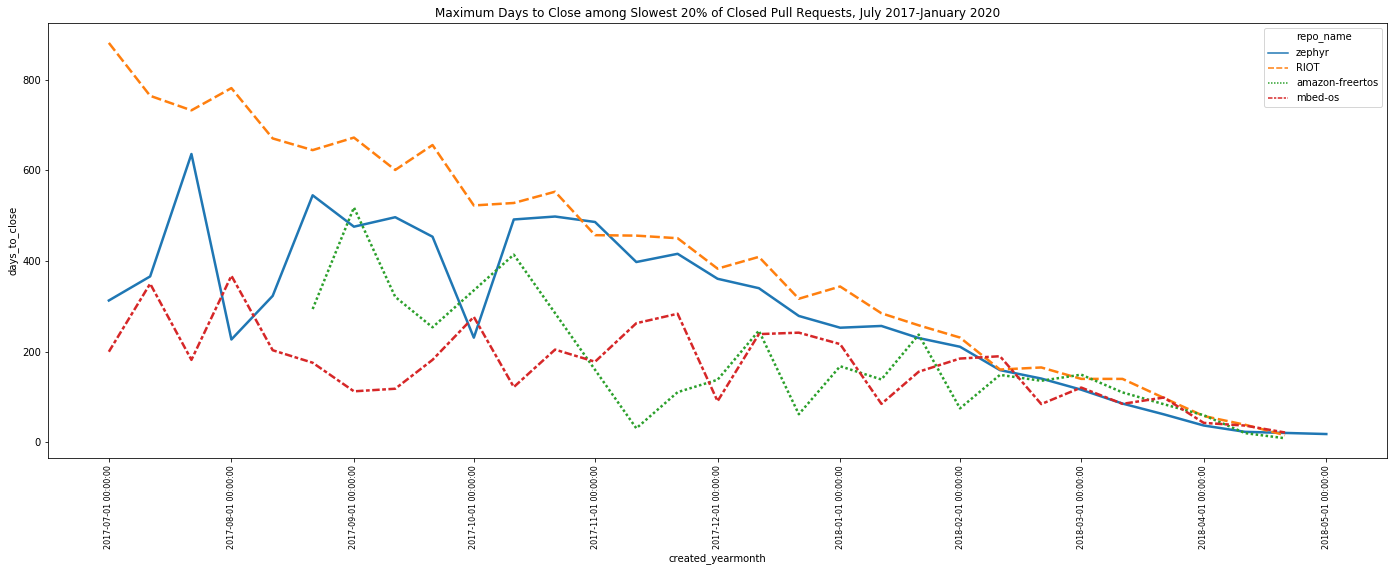

In [30]:
visualize_mean_min_max(pr_slow20_closed, x_axis='created_yearmonth', description='Closed', num_remove_min_outliers=5)

Indices to drop: Int64Index([62, 61, 64, 68], dtype='int64')


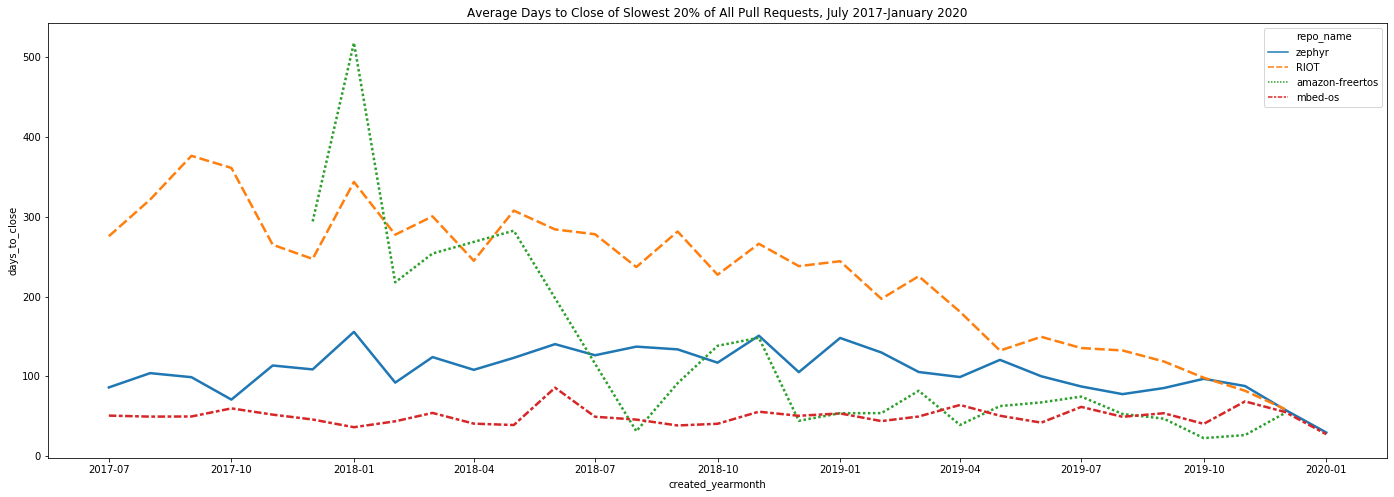

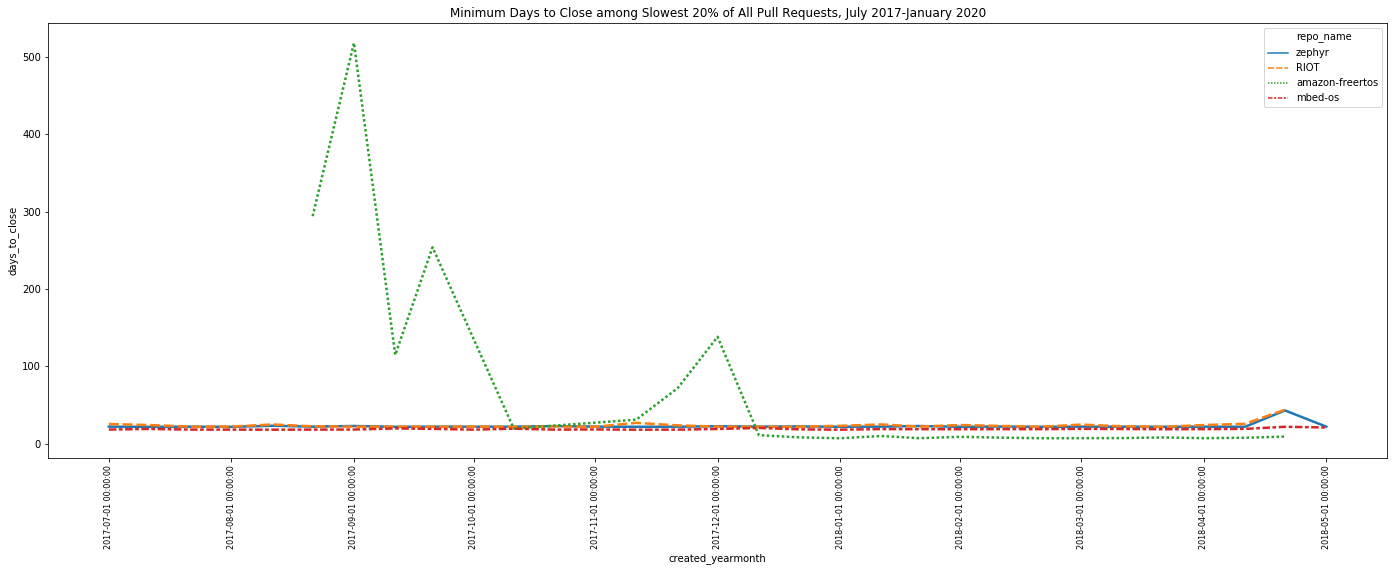

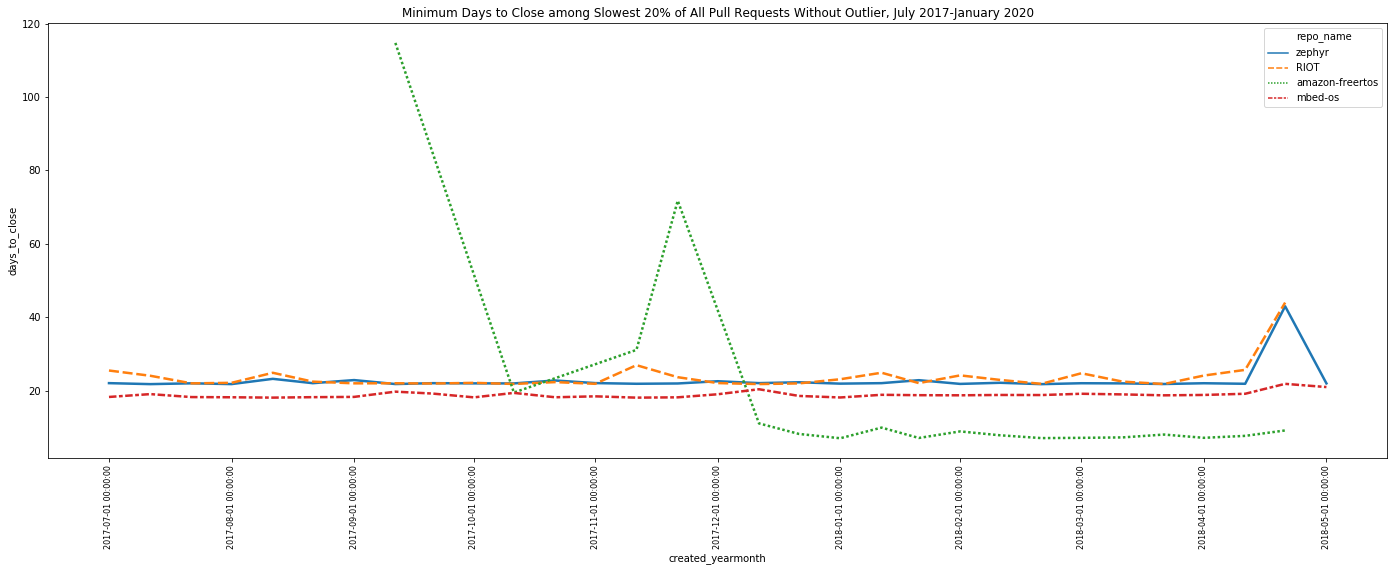

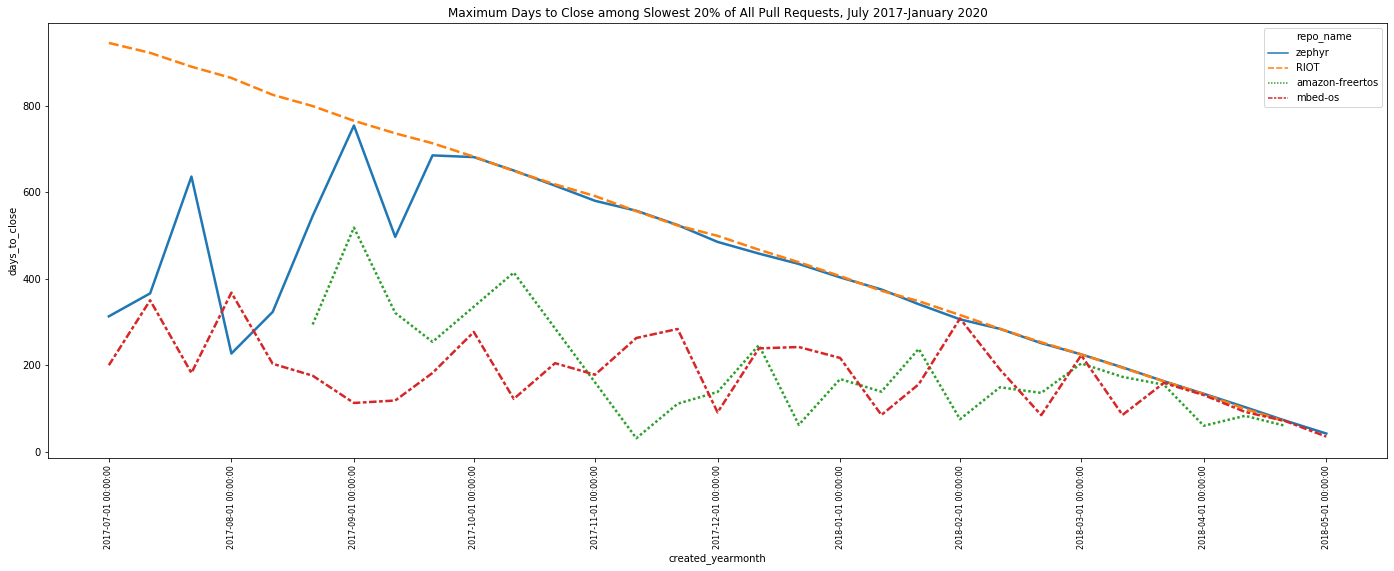

In [31]:
visualize_mean_min_max(pr_slow20_all, x_axis='created_yearmonth', description='All', num_remove_min_outliers=4)

Indices to drop: Int64Index([61], dtype='int64')


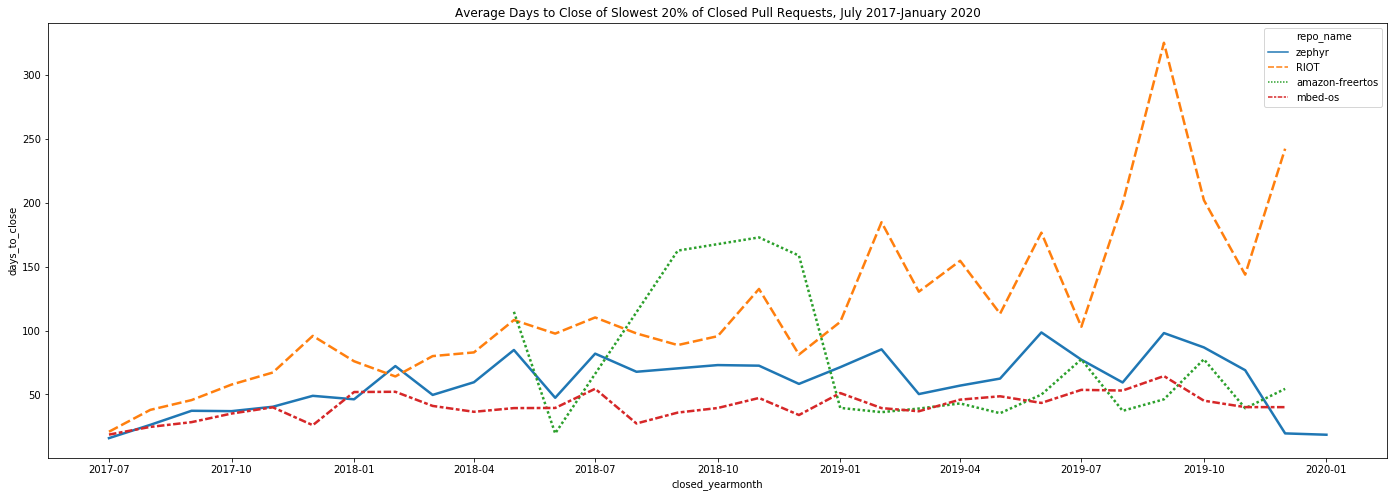

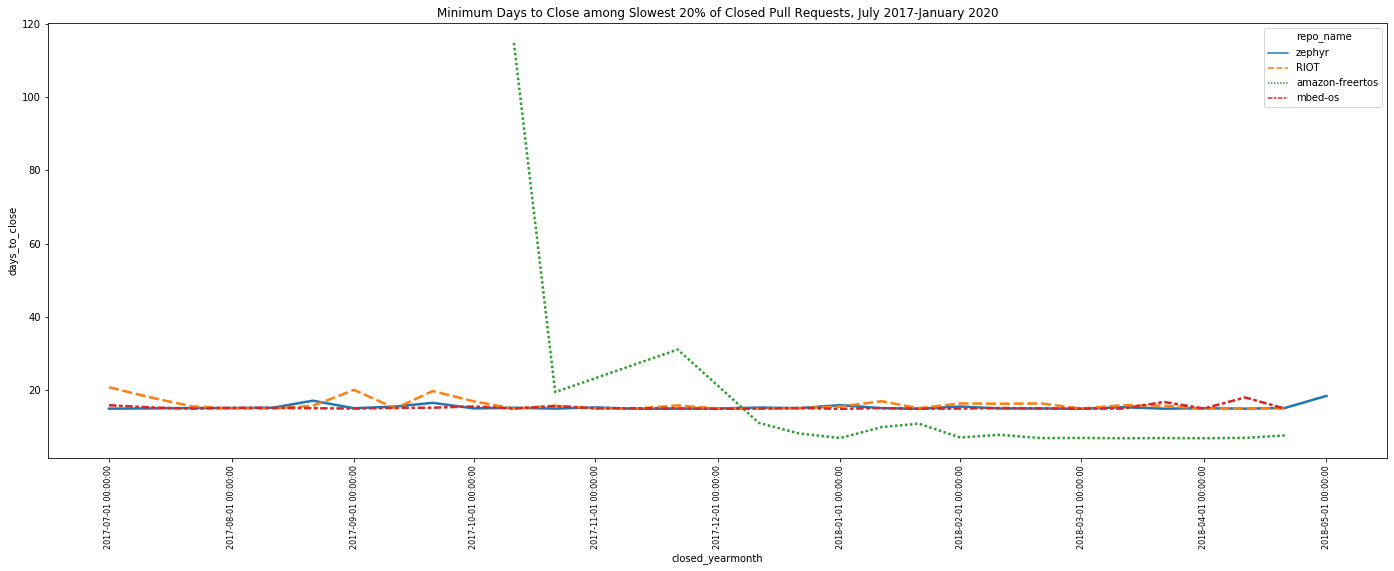

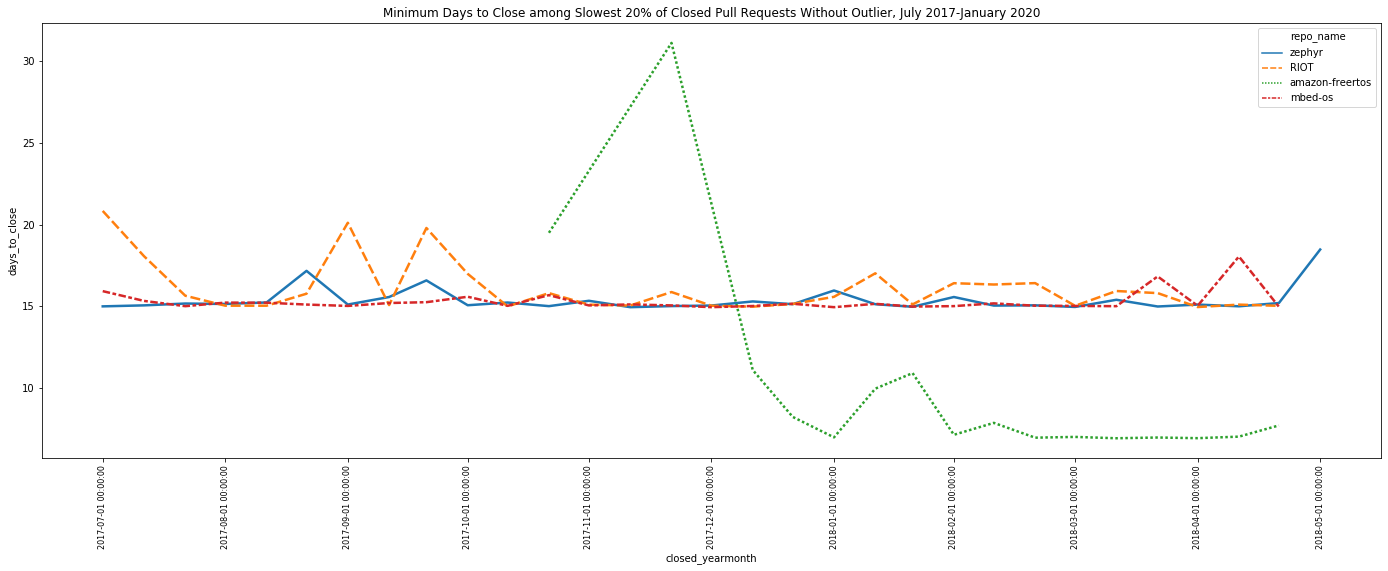

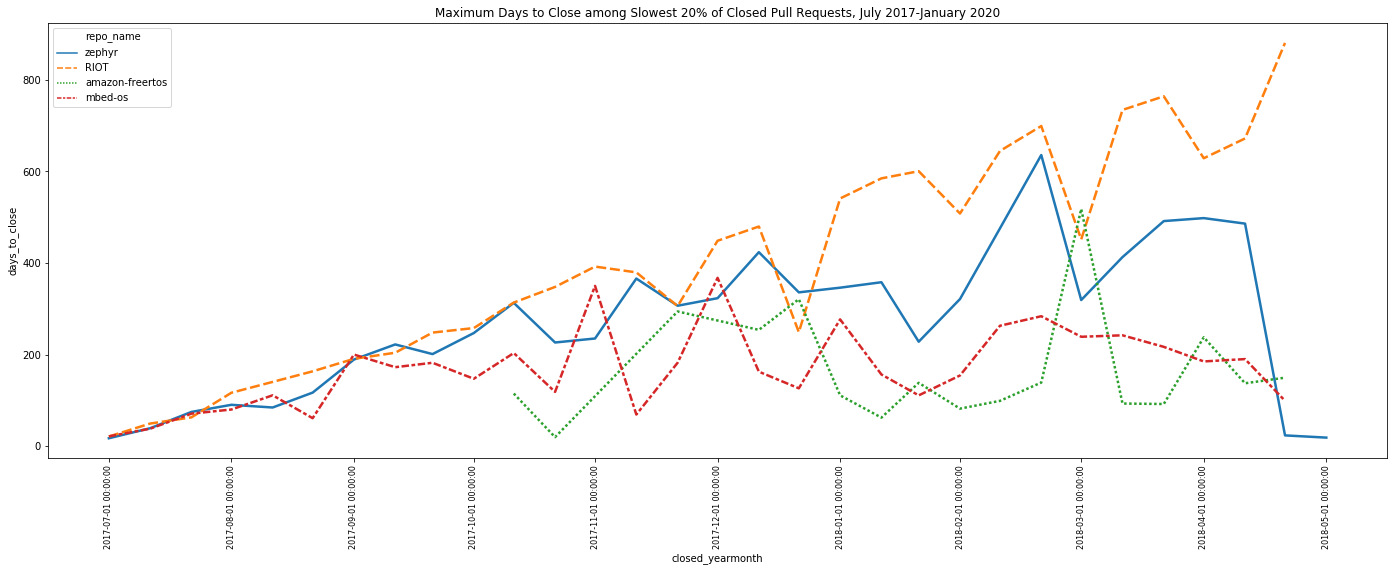

In [32]:
visualize_mean_min_max(pr_slow20_closed, x_axis='closed_yearmonth', description='Closed', num_remove_min_outliers=1)

In [11]:
""" Display raw data if desired """
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     display(driver_df.loc[driver_df['repo_name'] == "RIOT"])
# driver_df_max.loc[driver_df_max['repo_name'] == "RIOT"]

' Display raw data if desired '

### Merged vs Not Merged Pull Requests, July 2017-January 2020

In [237]:
important_columns = ['repo_name', 'pr_src_state', 'pr_created_at', 'pr_closed_at', 'days_to_close', 'created_yearmonth', 'closed_yearmonth']
pr_slow20_open_reduced = pr_slow20_open[important_columns]
pr_slow20_open_reduced = pr_slow20_open_reduced.rename(columns={'days_to_close': 'days_open'})

pr_slow20_closed_reduced = pr_slow20_closed[important_columns]
pr_slow20_closed_reduced = pr_slow20_closed_reduced.rename(columns={'days_to_close': 'days_open'})

pr_slow20_all_reduced = pr_slow20_all[important_columns]
pr_slow20_all_reduced = pr_slow20_all_reduced.rename(columns={'days_to_close': 'days_open'})
pr_slow20_all_reduced

,repo_name,pr_src_state,pr_created_at,pr_closed_at,days_open,created_yearmonth,closed_yearmonth
0,mbed-os,open,2019-12-26 22:27:43,NaT,47.000000,2019-12-01,NaT
1,mbed-os,open,2020-01-22 02:30:55,NaT,21.000000,2020-01-01,NaT
2,mbed-os,open,2020-01-21 16:26:37,NaT,21.000000,2020-01-01,NaT
3,mbed-os,open,2020-01-21 16:23:26,NaT,21.000000,2020-01-01,NaT
4,mbed-os,open,2020-01-21 15:06:54,NaT,21.000000,2020-01-01,NaT
...,...,...,...,...,...,...,...
1154,mbed-os,closed,2019-10-21 13:28:00,2019-11-12 09:59:40,21.855324,2019-10-01,2019-11-01
1155,mbed-os,closed,2018-01-04 16:11:32,2018-01-26 12:30:17,21.846354,2018-01-01,2018-01-01
1156,mbed-os,closed,2018-03-27 16:16:56,2018-04-18 12:20:13,21.835613,2018-03-01,2018-04-01
1157,mbed-os,closed,2019-09-23 09:43:29,2019-10-15 05:16:37,21.814676,2019-09-01,2019-10-01


In [238]:
print("Mean/min/max of the slowest 20% of open PRs: {0:.2f} / {1:.2f} / {2:.2f}\n".format(pr_slow20_open_reduced['days_open'].mean(),pr_slow20_open_reduced['days_open'].min(),pr_slow20_open_reduced['days_open'].max()))
print("Mean/min/max of the slowest 20% of closed PRs: {0:.2f} / {1:.2f} / {2:.2f}\n".format(pr_slow20_closed_reduced['days_open'].mean(),pr_slow20_closed_reduced['days_open'].min(),pr_slow20_closed_reduced['days_open'].max()))
print("Mean/min/max of the slowest 20% of all the PRs: {0:.2f} / {1:.2f} / {2:.2f}\n".format(pr_slow20_all_reduced['days_open'].mean(),pr_slow20_all_reduced['days_open'].min(),pr_slow20_all_reduced['days_open'].max()))

Mean/min/max of the slowest 20% of open PRs: 544.89 / 76.00 / 945.00

Mean/min/max of the slowest 20% of closed PRs: 86.24 / 6.93 / 881.01

Mean/min/max of the slowest 20% of all the PRs: 132.47 / 7.06 / 945.00



In [ ]:
import pandas_profiling as pp
profile = pp.ProfileReport(pr_slow20)

In [ ]:
profile.to_notebook_iframe()

In [ ]:
pr_slow20_summary = pr_slow20.groupby(['repo_id', 'repo_group', 'repo_name','closed_yearmonth','days_to_close']).mean()


In [ ]:
print(pr_slow20_summary)

In [ ]:

index = pd.MultiIndex.from_arrays(pr_slow20, names=['repo_id', 'repo_group', 'repo_name', 'closed_yearmonth'])
pr20x = pr_slow20.groupby(level=['repo_id', 'repo_group', 'repo_name', 'closed_yearmonth']).mean()

In [ ]:
                                     )['days_to_close'.mean(),
                                       'hours_to_close'.mean(),
                                       'pr_url'.count()
                                      ]

In [ ]:
pr_slow20.dtypes

In [ ]:
print(pr_slow20_summary)

In [ ]:
#Total PRS open and closed by month
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(24, 8)
plottermonth = sns.lineplot(x='yearmonth', y='total_prs_open_closed', style='repo_name', data=pr_slow20, sort=False, legend='full', linewidth=2.5, hue='repo_name').set_title("Total Pull Requests Closed by Month, July 2017-January 2020")   
#ax.tick_params(axis='x', which='minor', labelsize='small', labelcolor='m', rotation=30)
plottermonthlabels = ax.set_xticklabels(pr_monthDF['yearmonth'], rotation=90, fontsize=13)
fig.savefig('images/prs-slow20-monthly-total-open-closed.png')


#Average Days Open by Month
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(24, 24)
plottermonth = sns.lineplot(x='yearmonth', y='wk_avg_days_to_close', style='repo_name', data=pr_slow20, sort=False, legend='full', linewidth=2.5, hue='repo_name').set_title("Average Closed PR Time Open by Month, July 2017-January 2020")   
#ax.tick_params(axis='x', which='minor', labelsize='small', labelcolor='m', rotation=30)
plotterlabels = ax.set_xticklabels(pr_monthDF['yearmonth'], rotation=90, fontsize=8)
fig.savefig('images/prs-slow-average-open-time-month.png')


## Experimental Visualizations
### Slowest 20% Within a Repository

In [ ]:
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import datetime as dt
start_date = pd.to_datetime('2017-07-01 01:00:00')
end_date = pd.to_datetime('2020-02-01 09:00:00')
#https://github.com/mwaskom/seaborn/issues/1641


pr_slow20 = pr_slow20[(pr_slow20['pr_closed_at'] > start_date) & (pr_slow20['pr_closed_at'] < end_date)]
pr_slow20['date'] = pr_slow20['pr_closed_at'].dt.date


# Seaborn converts plotting inputs to numpy arrays
x = np.asarray(pr_slow20.date)
y = np.asarray(pr_slow20.days_to_close)


sns.set_style('ticks')
#sns.palplot(sns.color_palette('husl', 8))
#sns.set_palette('husl')
sns.set(style="whitegrid")

fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(24, 8)
plottermonth = sns.scatterplot(x='date', y='days_to_close', style='repo_name', data=pr_slow20,  legend='full', linewidth=2.5, hue='repo_name').set_title("Pull Requests Closed, July 2017-January 2020")   
#ax.tick_params(axis='x', which='minor', labelsize='small', labelcolor='m', rotation=30)
#plottermonthlabels = ax.set_xticklabels(pr_slow20['pr_closed_at'], rotation=90, fontsize=13)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
fig.savefig('images/prs-zephyr-slow20.png')
#ax.set(xlim=(2017,2020))




In [ ]:
pr_slow20['days_to_close'].plot.kde(bw_method=.3)
pr_slow20['days_to_close'].plot.kde(bw_method=3)
pr_slow20['days_to_close'].plot.kde(bw_method=7)
